In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Dict, Tuple
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math

from torchvision.datasets import CelebA
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [4]:
def ddpm_schedules_linear(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:

    assert beta1 < beta2 < 1.0

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

In [5]:
def ddpm_schedules_cosine(betas, T: int) -> Dict[str, torch.Tensor]:

    beta_t = torch.from_numpy(betas)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

In [6]:
beta1 = 1e-4
beta2 = 0.02
totalSteps = 200
imgs = []
imgs_cos = []
alpha_t, oneover_sqrta, sqrt_beta_t, alphabar_t, sqrtab, sqrtmab, mab_over_sqrtmab_inv = ddpm_schedules_linear(beta1, beta2, totalSteps).items()

sqrtab = sqrtab[1]
sqrtmab = sqrtmab[1]

In [7]:
def center_crop(img, dim):
  """Returns center cropped image

  Args:
  img: image to be center cropped
  dim: dimensions (width, height) to be cropped from center
  """

  width, height = img.shape[1], img.shape[0]
  #process crop width and height for max available dimension
  crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
  crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]

  mid_x, mid_y = int(width/2), int(height/2)
  cw2, ch2 = int(crop_width/2), int(crop_height/2) 
  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
  return crop_img

In [8]:
for i in range(totalSteps):
  #_ts = torch.randint(0, i+1, (x.shape[0],)).to(x.device)
  eps = torch.randn_like(x)
  x_t = (sqrtab[i, None, None, None] * x + sqrtmab[i, None, None, None] * eps)

  if i%20==0 or i==199:
    imgs.append(x_t)

for img in imgs:
  plt.figure()
  plt.imshow(img)


NameError: name 'x' is not defined

In [9]:
totalSteps = 200
imgs = []
betas = get_named_beta_schedule("cosine", totalSteps)
alpha_t_cos, oneover_sqrta_cos, sqrt_beta_t_cos, alphabar_t_cos, sqrtab_cos, sqrtmab_cos, mab_over_sqrtmab_inv_cos = ddpm_schedules_cosine(betas, totalSteps).items()

sqrtab_cos = sqrtab_cos[1]
sqrtmab_cos = sqrtmab_cos[1]

In [10]:
for i in range(totalSteps):
  #_ts = torch.randint(0, i+1, (x.shape[0],)).to(x.device)
  eps = torch.randn_like(x)
  x_t = (sqrtab_cos[i, None, None, None] * x + sqrtmab_cos[i, None, None, None] * eps)

  if i%20==0 or i==199:
    imgs_cos.append(x_t)

for img in imgs_cos:
  plt.figure()
  plt.imshow(img)


NameError: name 'x' is not defined

In [11]:
import cv2
xtest = x.numpy()
test = cv2.resize(xtest, (80,80), interpolation = cv2.INTER_CUBIC)
test2 = cv2.resize(xtest, (40,40), interpolation = cv2.INTER_CUBIC)

plt.figure()
plt.imshow(test2)
plt.figure()
plt.imshow(test)

NameError: name 'x' is not defined

#DDPM

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inchan, outchan, 5, 1, 2),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outchan, outchan, 5, 1, 2),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class ConvBlockSmall(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inchan, outchan, 3, 1, 1),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outchan, outchan, 3, 1, 1),
            nn.BatchNorm2d(outchan),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class Down(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(Down, self).__init__()
        layers = [
            ConvBlock(inchan, outchan),
            nn.MaxPool2d(2),
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class Up(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(Up, self).__init__()
        layers = [
            nn.ConvTranspose2d(inchan, outchan, 2, 2),
            ConvBlock(outchan, outchan),
            ConvBlock(outchan, outchan),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
        x1 = torch.cat((x, res), 1)
        x2 = self.model(x1)
        return x2

class BottomDown(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(BottomDown, self).__init__()
        layers = [
            ConvBlockSmall(inchan, outchan),
            nn.MaxPool2d(2),
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class BottomUp(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(BottomUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(inchan, outchan, 2, 2),
            ConvBlockSmall(outchan, outchan),
            ConvBlockSmall(outchan, outchan),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.model(x)
        return x1
    
class EmbeddingLR(nn.Module):
    def __init__(self, inchan: int, outchan: int) -> None:
        super(EmbeddingLR, self).__init__()
        layers = [
            nn.ConvTranspose2d(inchan, outchan, 2, 2),
            nn.Conv2d(outchan, outchan, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(outchan,outchan,2,2),
            nn.Conv2d(outchan, outchan, 3, 1, 1),
            nn.ReLU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.model(x)
        return x1

class EmbeddingNN(nn.Module):
    def __init__(self, indim, outdim):
        super(EmbeddingNN, self).__init__()

        self.indim = indim
        layers = [
            nn.Linear(indim, outdim),
            nn.ReLU(),
            nn.Linear(outdim, outdim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.indim)
        return self.model(x)


class UncondUnet(nn.Module):
    def __init__(self, inchan: int, outchan: int, n_feat: int = 128) -> None:
        super(UncondUnet, self).__init__()

        self.inchan = inchan
        self.n_feat = n_feat

        self.init_conv = ConvBlock(inchan, n_feat)

        self.down1 = Down(n_feat+16, n_feat)
        self.down2 = Down(n_feat, 2*n_feat)
        self.down3 = BottomDown(2*n_feat, 4*n_feat)

        self.timeembed = EmbeddingNN(1, 800)
        self.LRembed = EmbeddingLR(3,16)

        self.up0 = BottomUp(4*n_feat+2,2*n_feat)
        self.up1 = Up(4*n_feat, n_feat)
        self.up2 = Up(2*n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2*n_feat+16, n_feat, 5, 1, 2),
            nn.BatchNorm2d(n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.inchan, 5, 1, 2),
        )

    def forward(self, x, t, LR):

        x = self.init_conv(x)
        
        LRembed = self.LRembed(LR.view(-1,3,40,40))
        
        x_concat = torch.cat((x, LRembed),1)
        
        down1 = self.down1(x_concat)
        down2 = self.down2(down1)

        #down2_concat = torch.cat((down2, LR.view(-1,3,40,40)), 1)

        down3 = self.down3(down2) #2*n_featby3by3

        timeembed = self.timeembed(t).view(-1,2, 20, 20) #n_featby3by3
        bottom = torch.cat((down3, timeembed), 1) #3*n_featby3by3

        up1 = self.up0(bottom)
        up2 = self.up1(up1, down2)
        up3 = self.up2(up2, down1)
        out = self.out(torch.cat((up3, x_concat), 1))
        return out

In [13]:
from random import randrange

class DDPMcond(nn.Module):
    def __init__(self,noisemodel: nn.Module,betas: Tuple[float, float],totalSteps: int,criterion: nn.Module = nn.MSELoss(),) -> None:
        super(DDPMcond, self).__init__()
        self.noisemodel = noisemodel

        for k, v in ddpm_schedules(betas[0], betas[1], totalSteps).items():
            self.register_buffer(k, v)

        self.totalSteps = totalSteps
        self.criterion = criterion

    def forward(self, x: torch.Tensor, LR) -> torch.Tensor:

        _ts = torch.randint(1, self.totalSteps + 1, (x.shape[0],)).to(x.device)
        eps = torch.randn_like(x)
        #print(self.sqrtab.shape)
        #print(self.sqrtmab.shape)
        #print(_ts)

        x_t = (self.sqrtab[_ts, None, None, None] * x + self.sqrtmab[_ts, None, None, None] * eps)

        return self.criterion(eps, self.noisemodel(x_t, _ts / self.totalSteps, LR))

    def sample(self, n_sample: int, size, device, sample_nr) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)
        x_i_process = []
        #label_i = torch.arange(0,10).to(device)
        #a = randrange(15000)
        LR,_ = datasetLRtest[sample_nr]
        HR,_ = datasetHRtest[sample_nr]
        LR = LR.to(device)

        for i in range(self.totalSteps, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.noisemodel(x_i, torch.tensor(i / self.totalSteps).to(device), LR)
            x_i = (self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i]) + self.sqrt_beta_t[i] * z)
            if i%20==0 or i==self.totalSteps-1:
              x_i_process.append(x_i.detach().cpu().numpy())

        return x_i, x_i_process, LR, HR


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:

    assert beta1 < beta2 < 1.0

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}} 
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [14]:
tf = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
        [
            transforms.Resize((160, 160), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

tf2 = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
        [
            transforms.Resize((40, 40), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [19]:
datasetHR = CelebA("./dataHR", split='train', download=False, transform=tf,)
datasetLR = CelebA("./dataLR", split='train', download=False, transform=tf2,)

dataloaderHR = DataLoader(datasetHR, batch_size=32, shuffle=False, num_workers=2)
dataloaderLR = DataLoader(datasetLR, batch_size=32, shuffle=False, num_workers=2)

In [19]:
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CelebA
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

grids = []
losses = []

def train_mnistcond(
    n_epoch: int = 10, device: str = "cuda:0") -> None:

    ddpmcond = DDPMcond(noisemodel=UncondUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), totalSteps=500)
    ddpmcond.to(device)

    optim = torch.optim.Adam(ddpmcond.parameters(), lr=1e-4)

    for i in range(n_epoch):
        print(f"Epoch {i}: ")
        ddpmcond.train()

        optim.param_groups[0]['lr'] = 1e-4*(1-i/n_epoch)

        #pbarHR = tqdm(dataloaderHR)
        #pbarLR = tqdm(dataloaderLR)
        for (HR,_),(LR,_) in zip(dataloaderHR, dataloaderLR):
            ddpmcond.train()
            optim.zero_grad()
            HR = HR.to(device)
            LR = LR.to(device)

            loss = ddpmcond(HR, LR)
            loss.backward()
            losses.append(loss.cpu())
            #pbarHR.set_description(f"loss: {loss:.4f}")
            optim.step()

        ddpmcond.eval()
        print(i)
        #pbarHR.set_description(f"loss: {loss:.4f}")
        #with torch.no_grad():
            #xh, xp = ddpmcond.sample(10, (1, 28, 28), device)
            #grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=10)
            #save_image(grid, f"./ddpmcond/ddpmcond_sample{i}.png")
            #grids.append(grid)

        torch.save(ddpmcond.state_dict(), f"./ddpm4xlin500.pth")

if __name__ == "__main__":
  train_mnistcond()

Epoch 0: 
torch.Size([501])
torch.Size([501])
tensor([ 59, 346,  89, 354, 325, 339,  18, 379, 166, 219, 446, 259, 286, 324,
        182, 343, 461, 286, 124, 332, 255, 366,   5, 494, 135, 266, 134, 294,
        419, 141, 326, 397])


KeyboardInterrupt: 

In [16]:
xlab = list(range(len(losses)))

for i in range(len(losses)):
    losses[i] = losses[i].detach().numpy()
    

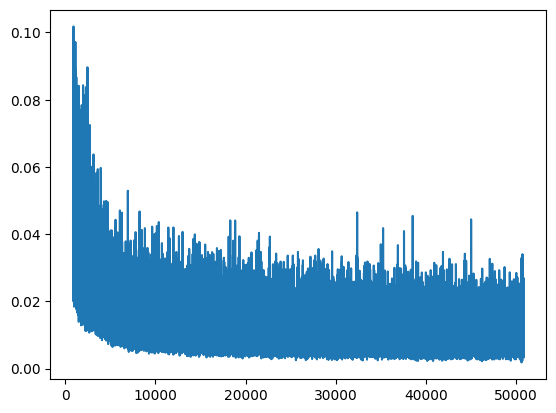

In [18]:
plt.plot(xlab[-50000:], losses[-50000:])

In [15]:
datasetHRtest = CelebA("./dataHRtest", split='test', download=False, transform=tf,)
datasetLRtest = CelebA("./dataLRtest", split='test', download=False, transform=tf2,)

In [16]:
device = "cuda:0"

ddpmcond = DDPMcond(noisemodel=UncondUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), totalSteps=500)
ddpmcond.load_state_dict(torch.load(f"./ddpm4xlin500.pth"))
ddpmcond.to(device)

DDPMcond(
  (noisemodel): UncondUnet(
    (init_conv): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (down1): Down(
      (model): Sequential(
        (0): ConvBlock(
          (conv1): Sequential(
            (0): Conv2d(144, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): BatchNorm2d(128, 

In [17]:
pytorch_total_params = sum(p.numel() for p in ddpmcond.parameters() if p.requires_grad)
print(pytorch_total_params)

15383267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


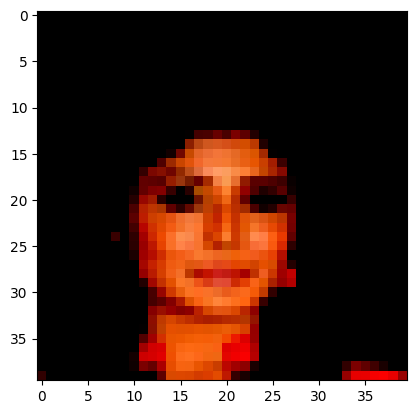

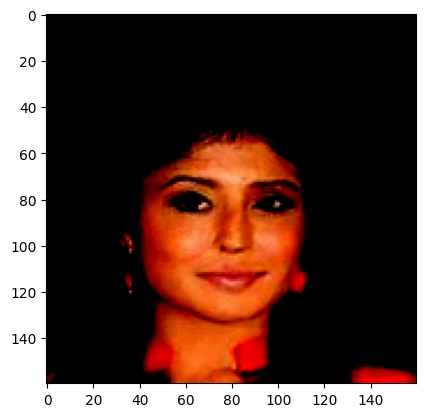

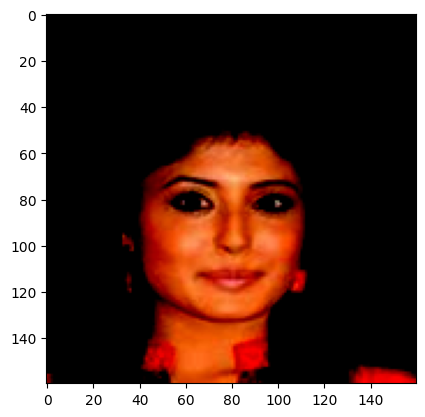

In [44]:
from torchvision.utils import save_image, make_grid

ddpmcond.eval()
with torch.no_grad():
    xh, xp, LR, HR = ddpmcond.sample(1, (3, 160, 160), device, 666)
    LR = LR.cpu()
    grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=1)
    plt.figure()
    plt.imshow(LR.permute(1,2,0))
    plt.figure()
    plt.imshow(grid.permute(1,2,0))
    plt.figure()
    plt.imshow(HR.permute(1,2,0))
  #plt.axis('off')

In [18]:
from torchvision.utils import save_image, make_grid

ddpmcond.eval()
with torch.no_grad():
    for i in range(2000):
        xh, _, _, _ = ddpmcond.sample(1, (3, 160, 160), device, i)
        grid = make_grid(xh.cpu(), normalize=False, value_range=(-1, 1), nrow=1)
        save_image(grid, f"./DDPM4xlin500samples/4xlin500_sample{i}.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([11, 1, 3, 160, 160])


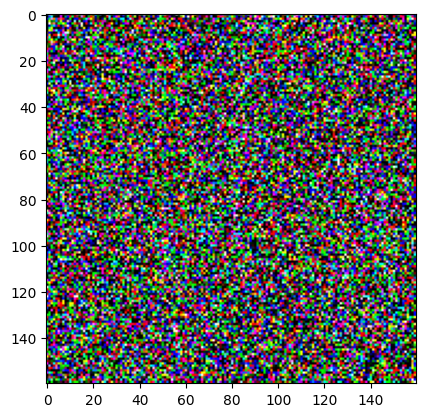

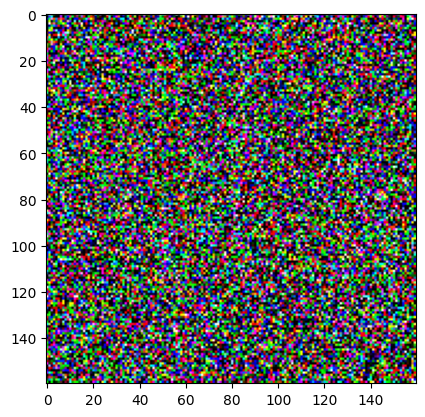

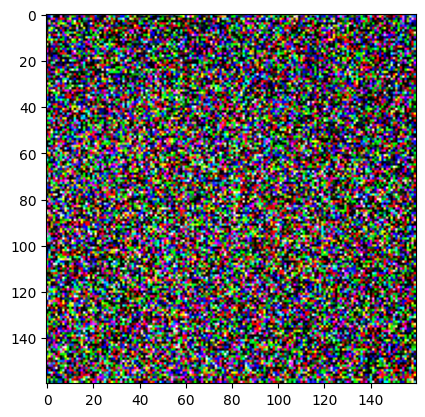

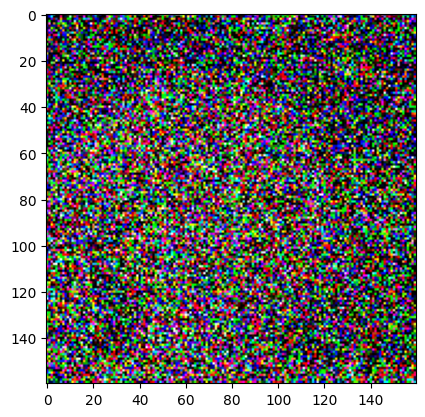

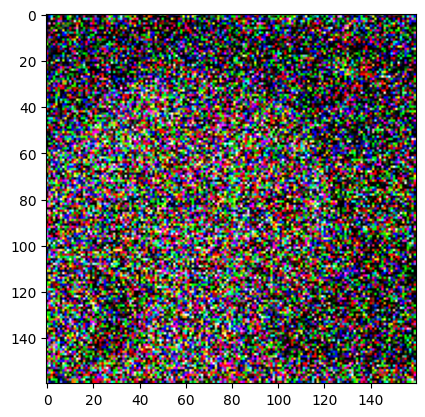

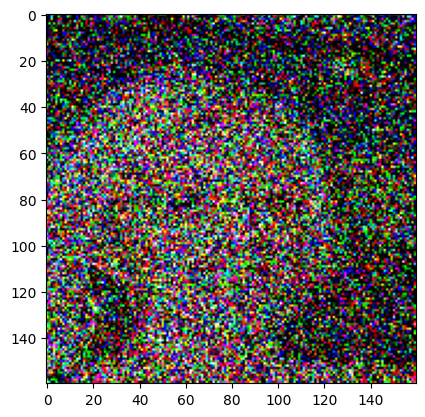

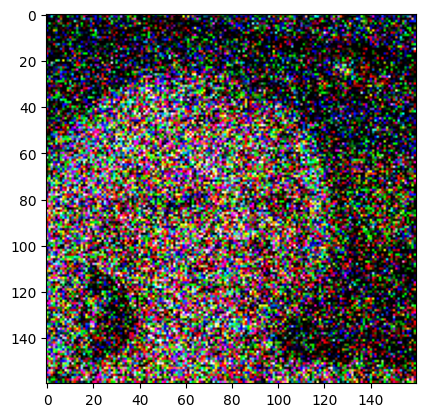

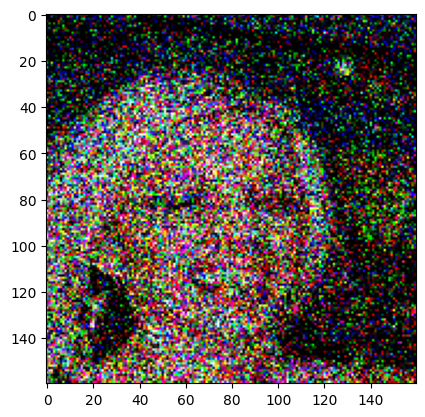

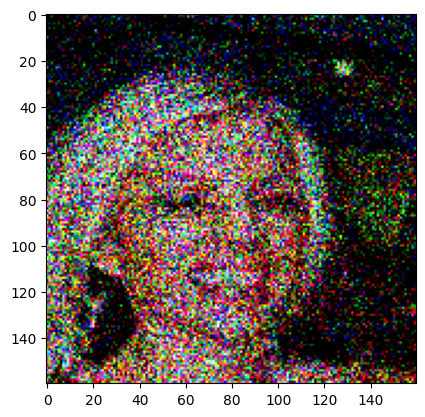

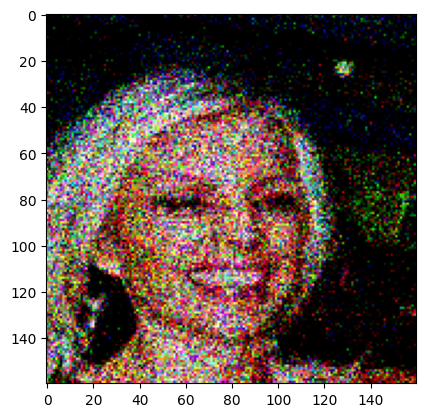

In [64]:
xp = torch.Tensor(xp)
print(xp.shape)

for i in range(10):
  gridlearn = make_grid(xp[i], normalize=False, value_range=(-1,1), nrow=10)

  plt.figure()
  plt.imshow(gridlearn.permute(1,2,0))
  #plt.axis('off')

In [35]:
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import cv2

MSE_list = []

for i in range(100):
    # Load the images
    img1 = cv2.imread(f"./DDPM4xlin500samples/4xlin500_sample{i}.png")
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img1 = img1.astype(np.uint8)

    img2 = cv2.imread(f"./TESTDATAHR/HRsample_{i}.png")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img2 = img2.astype(np.uint8)
    
    # Calculate the mean squared error between the images
    mse = np.mean((img1 - img2) ** 2)

    # Calculate the maximum pixel value of the images
    max_pixel_value = 255.0

    # Calculate the PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    MSE_list.append(psnr)

In [36]:
PSNR = sum(MSE_list)/len(MSE_list)
PSNR

34.91392494458719

In [33]:
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import cv2

SSIM_list = []

for i in range(100):
    # Load the images
    img1 = cv2.imread(f"./DDPM4xlin500samples/4xlin500_sample{i}.png")
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img1 = img1.astype(np.uint8)

    img2 = cv2.imread(f"./TESTDATAHR/HRsample_{i}.png")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img2 = img2.astype(np.uint8)

    # Convert the images to grayscale
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # Calculate the SSIM
    ssim_score = ssim(gray_img1, gray_img2)
    SSIM_list.append(ssim_score)

In [34]:
SSIM = sum(SSIM_list)/len(SSIM_list)
SSIM

0.8735422867479358

In [16]:
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import cv2

LRMSE_list = []

for i in range(100):
    # Load the images
    img1 = cv2.imread(f"./DDPM4xlin500samples/4xlin500_sample{i}.png")
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img1 = img1.astype(np.uint8)
    img1 = cv2.resize(img1, (40, 40), interpolation=cv2.INTER_CUBIC)

    img2 = cv2.imread(f"./TESTDATALR/LRsample_{i}.png")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    #img1 = img1.permute(1,2,0).numpy()
    img2 = img2.astype(np.uint8)
    
    # Calculate the mean squared error between the images
    mse = np.mean((img1 - img2) ** 2)

    # Calculate the maximum pixel value of the images
    max_pixel_value = 255.0

    # Calculate the PSNR
    LRpsnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    LRMSE_list.append(LRpsnr)

In [17]:
LRPSNR = sum(LRMSE_list)/len(LRMSE_list)
LRPSNR

35.62618706082496